In [126]:
import os
import sys
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=3,3


sys.path.append('/home/chris/src/provenance_py')

if __name__ == "__main__" and __package__ is None:
    __package__ = "provenance_lib"

from .parse import ProvDAG, ProvNode, Config


In [141]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    Adapted from Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    G: the graph (our single-ProvDAG graphs are always trees)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

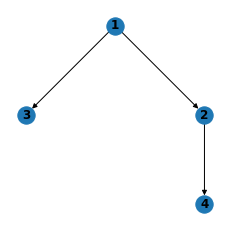

In [142]:
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3, 4], att='gerbil')
G.add_edge(1, 3)
G.add_edge(1, 2)
G.add_edge(2, 4)
G.nodes

pos = hierarchy_pos(G,1)    
nx.draw(G, pos=pos, with_labels=True, font_weight="bold")

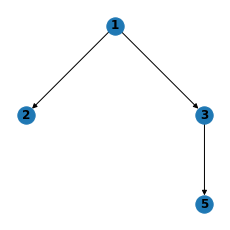

In [147]:
H = nx.DiGraph()
H.add_nodes_from([1, 2, 3, 5], att='gerbil')
H.add_edge(1, 2)
H.add_edge(1, 3)
H.add_edge(3, 5)

pos = hierarchy_pos(H,1)    
nx.draw(H, pos=pos, with_labels=True, font_weight="bold")

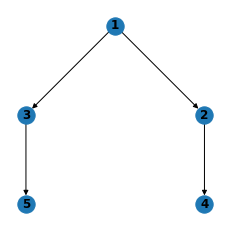

In [149]:
# Compose works as we would expect union to work
R = nx.compose(G, H)
pos = hierarchy_pos(R, 1) 
nx.draw(R, pos=pos, with_labels=True, font_weight="bold")

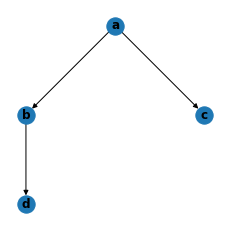

In [153]:
# Repeat the exercise with classes
class Point():
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y
    
    def __repr__(self):
        return f'{self.name}'
        

a = Point('a', 0, 0)
b = Point('b', 1, 1)
c = Point('c', 2, 2)
d = Point('d', 3, 3)
e = Point('e', 4, 4)

I = nx.DiGraph()
I.add_nodes_from([a, b, c, d])
I.add_edge(a, b)
I.add_edge(a, c)
I.add_edge(b, d)
# Root is None so computes root - use UUID if we do this IRL
pos = hierarchy_pos(I) 
nx.draw(I, pos=pos, with_labels=True, font_weight="bold")

[0, 1, 2, 3]
[(0, {'universal': '555', 'uuid': a}), (1, {'universal': '555', 'uuid': b, 'gerbil': True}), (2, {'universal': '555', 'uuid': c}), (3, {'universal': '555', 'uuid': e})]
[(0, a), (1, b), (2, c), (3, e)]
[(0, None), (1, True), (2, None), (3, None)]
[(0, False), (1, True), (2, False), (3, False)]
[1]
b


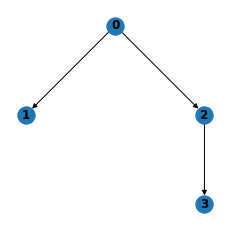

In [155]:
J = nx.DiGraph()
J.add_nodes_from([a, b, c, e], universal="555")
J.add_edge(a, b)
J.add_edge(a, c)
J.add_edge(c, e)

# Poke at names and things
J_r = nx.relabel.convert_node_labels_to_integers(J, label_attribute='uuid')
J_r.nodes[1]['gerbil'] = True

# Demonstrate data access
print(J_r.nodes)
print(J_r.nodes(data=True))
print(J_r.nodes(data="uuid"))
print(J_r.nodes(data="gerbil"))
# Sets all None values to False
print(J_r.nodes(data="gerbil", default = False))
pos = hierarchy_pos(J_r)
nx.draw(J_r, pos=pos, with_labels=True, font_weight="bold")

# Get all nodes with node attribute set in nx node
gerbils = [node[0] for node in J_r.nodes(data="gerbil") if node[1] is not None]
print(gerbils)

# Get all node with node attribute set in Object
# This fails, because the 0 in the node view is not the object, it's the int label:
# xs = [node[0].x for node in J.nodes(data=True)]

J.nodes[b]['universal']
# print(<__main__.Point object at 0x7f0768e3ab50>)
print(b)

True

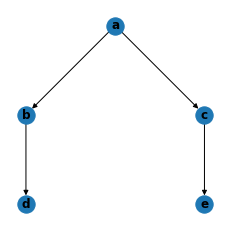

In [176]:
S = nx.compose(I, J)
pos = hierarchy_pos(S)
nx.draw(S, pos=pos, with_labels=True, font_weight="bold")
# Tree required hierarchy_pos
nx.is_tree(S)